In [1]:
import numpy as np 
import sklearn
from sklearn.decomposition import PCA
import pickle
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import h5py
import scipy
import vcf
import allel
import sys
import random
random.seed(42)
import time
sns.set_style('white')
sns.set_style('ticks')
np.set_printoptions(threshold=sys.maxsize)

In [2]:
#load in our pickled data that contains population_dict samples
population_dict = pickle.load(open("populationcodes.pkl", "rb"))
#hard code all of our sample lists into lists so that we can use for our read_vcf function
FIN_samples = list(population_dict['FIN'])
CHS_samples = list(population_dict['CHS'])
GBR_samples = list(population_dict['GBR'])
PUR_samples = list(population_dict['PUR'])
CLM_samples = list(population_dict['CLM'])
MXL_samples = list(population_dict['MXL'])
TSI_samples = list(population_dict['TSI'])
LWK_samples = list(population_dict['LWK'])  
JPT_samples = list(population_dict['JPT'])
IBS_samples = list(population_dict['IBS'])
PEL_samples = list(population_dict['PEL'])
CDX_samples = list(population_dict['CDX'])
YRI_samples = list(population_dict['YRI'])
KHV_samples = list(population_dict['KHV']) 
ASW_samples = list(population_dict['ASW']) 
ACB_samples = list(population_dict['ACB']) 
CHB_samples = list(population_dict['CHB'])
GIH_samples = list(population_dict['GIH']) 
GWD_samples = list(population_dict['GWD']) 
PJL_samples = list(population_dict['PJL'])
MSL_samples = list(population_dict['MSL'])
BEB_samples = list(population_dict['BEB']) 
ESN_samples = list(population_dict['ESN'])
STU_samples = list(population_dict['STU'])
ITU_samples = list(population_dict['ITU']) 

#create a list of population sample code lists so that we can iterate through and call each subpopulation sample set into our VCF file. 
sample_names_ls = [FIN_samples,
CHS_samples,
GBR_samples,
PUR_samples,
CLM_samples,
MXL_samples,
TSI_samples,
LWK_samples,
JPT_samples,
IBS_samples,
PEL_samples,
CDX_samples,
YRI_samples,
KHV_samples,
ASW_samples,
ACB_samples,
CHB_samples,
GIH_samples,
GWD_samples,
PJL_samples,
MSL_samples,
BEB_samples,
ESN_samples,
STU_samples,
ITU_samples]

In [3]:
#create a function that takes in our population genotype at each position and adds together the amount of variant alleles that are present resulting in a (calls x samples) matrix size
def allele_counter(population_gt, population_size):
    population_new_gt = []
    for i in range(0,population_size): 
        new_gt = population_gt[:,i,0] + population_gt[:,i,1]
        population_new_gt.append(new_gt)
    return population_new_gt

In [4]:
#try calling our dataset for Finnish_in_Finland population
callset = allel.read_vcf('ALL.chr21.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased.vcf',tabix = '/Users/AlexGaujean/Downloads/Genomics_Project/ALL.chr21.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased.vcf.gz.tbi', samples = FIN_samples) 

#run our genotype functions on our specified Finnish callset
#slice down our call dataset so we can work on it with more ease  
# FIN_new_gt = allele_counter(FIN_gt_slice, 100)

#run our callset data and subsequent functions for our Chinese population
callset_1 = allel.read_vcf('ALL.chr21.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased.vcf',tabix = '/Users/AlexGaujean/Downloads/Genomics_Project/vcf_zip_files/htslib-1.9/tabix.c' , samples = CHS_samples)
#setup our CHS genotype call files
# CHS_new_gt = allele_counter(CHS_gt_slice, 92)
#setup a slice of our CHS file so that we can work with a more manageable set of data


/Users/AlexGaujean/anaconda3/lib/python3.7/site-packages/allel/io/vcf_read.py:1631: UserWarning: some samples not found, will be ignored: 'HG00418', 'HG00427', 'HG00501', 'HG00512', 'HG00577', 'HG00578', 'HG00635', 'HG00702'
  ', '.join(map(repr, sorted(samples))))


-----------

In [5]:
#going to start by using a chunked array which doesnt store our data locally so we can work with it faster 
FIN_gt = allel.GenotypeChunkedArray(callset['calldata/GT'])
CHS_gt = allel.GenotypeChunkedArray(callset_1['calldata/GT'])

In [6]:
#count the alleles for our chunked dataframes
# FIN_gt_ac= allele_counter(FIN_gt, 100) 
# CHS_gt_ac = allele_counter(CHS_gt, 92)

In [7]:
#add our two arrays together so we have one large array with all of our samples
FIN_CHS_gt = np.concatenate([FIN_gt, CHS_gt], axis=1)
#create an allele count for our columns and filter out the rows that are not that don't satisfy our requirements
ac = FIN_gt.count_alleles()[:] + CHS_gt.count_alleles()[:]
flt = ac[:, :2].min(axis=1) > 1

#recompress that back to our original file
FIN_CHS_gt_filtered = FIN_CHS_gt.compress(flt, axis=0)


In [8]:
#count the alternate alleles for our dataframe in each row
FIN_CHS_gt_filtered.shape
#turn our array into a gt chunked array object
FIN_CHS_gt_filtered = allel.GenotypeChunkedArray(FIN_CHS_gt_filtered)
#use the to_n_alt() method to compress our GenotypeChunkedArray
FIN_CHS_gt_filtered = FIN_CHS_gt_filtered.to_n_alt() 

-------------

In [10]:
#create a function that will calculate the allele counts for each population filter out the rows that don't have enough SNPs and return our GT array with relevant values
def pca_configuration(pop_1_gt, pop_2_gt):
    pop_allele_count = pop_1_gt.count_alleles()[:] + pop_2_gt.count_alleles()[:] 
    pop_cat = np.concatenate([pop_1_gt, pop_2_gt], axis =1)
    pca_selection = pop_allele_count[:, :2].min(axis=1) > 1
    pop_cat = pop_cat.compress(pca_selection, axis=0)
    pop_cat = allel.GenotypeChunkedArray(pop_cat)
    pop_cat_filtered = pop_cat.to_n_alt() 
    indices = np.nonzero(pca_selection)[0]
    return pop_cat_filtered

# __Removing Correlated SNPs__

__Basepair Linkage__

A deeper understanding of the mechanisms that replicate our DNA sheds light on the issue of correlation. Base pair linkage, as it is referred to in the world of biology, means that certain SNPs will be correlated due to their proximity on the chromosome. This issue of segregating alleles is something that we must deal with before we input our data for PCA.

__Linkage Disequilibrium (LD)__  is the correlation between nearby variants such that the alleles at neighboring polymorphisms (observed on the same chromosome) are associated within a population more often than if they were unlinked.

In [11]:
from allel import plot as aplot
from allel import stats

In [12]:
#define a function that examines the linkage between SNPs in our sample through allel.rogers_huff_r method which is used to calculate variants that segregate together
def plot_ld(gn, title):
    m = allel.rogers_huff_r(gn) ** 2
    ax = aplot.pairwise_ld(m)
    ax.set_title(title)

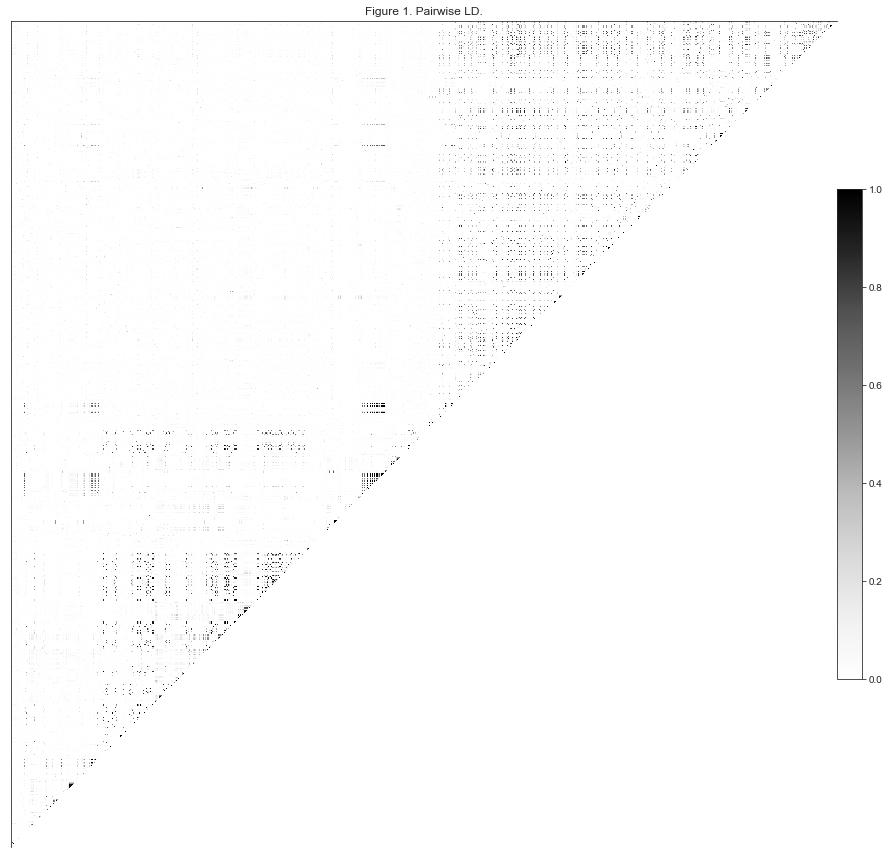

In [13]:
#examine a slice of our filtered_gt array where the dark spots represent a large value for our rogers_huff_r value which determines gene linkage
plot_ld(FIN_CHS_gt_filtered[:1000], 'Figure 1. Pairwise LD.')

*__Fig 1__. the dark spots on this pairwise graph is evidence that within our dataset we have SNPs that are segregating together*

In [14]:
#create a function that takes population_gt as input and prunes the variants to remove nucleotide polymorphisms that exhibit Linkage Disequilibrium
def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        print(n)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

In [15]:
#use a window size of 50 and step of 20 SNPs with a threshold of .1 for our r^2 value according to Rogers & Huff (2008)
FIN_CHS_gt_prune = ld_prune(FIN_CHS_gt_filtered, size=50, step=20, threshold=.1, n_iter=1)

48335
iteration 1 retaining 48335 removing 120733 variants


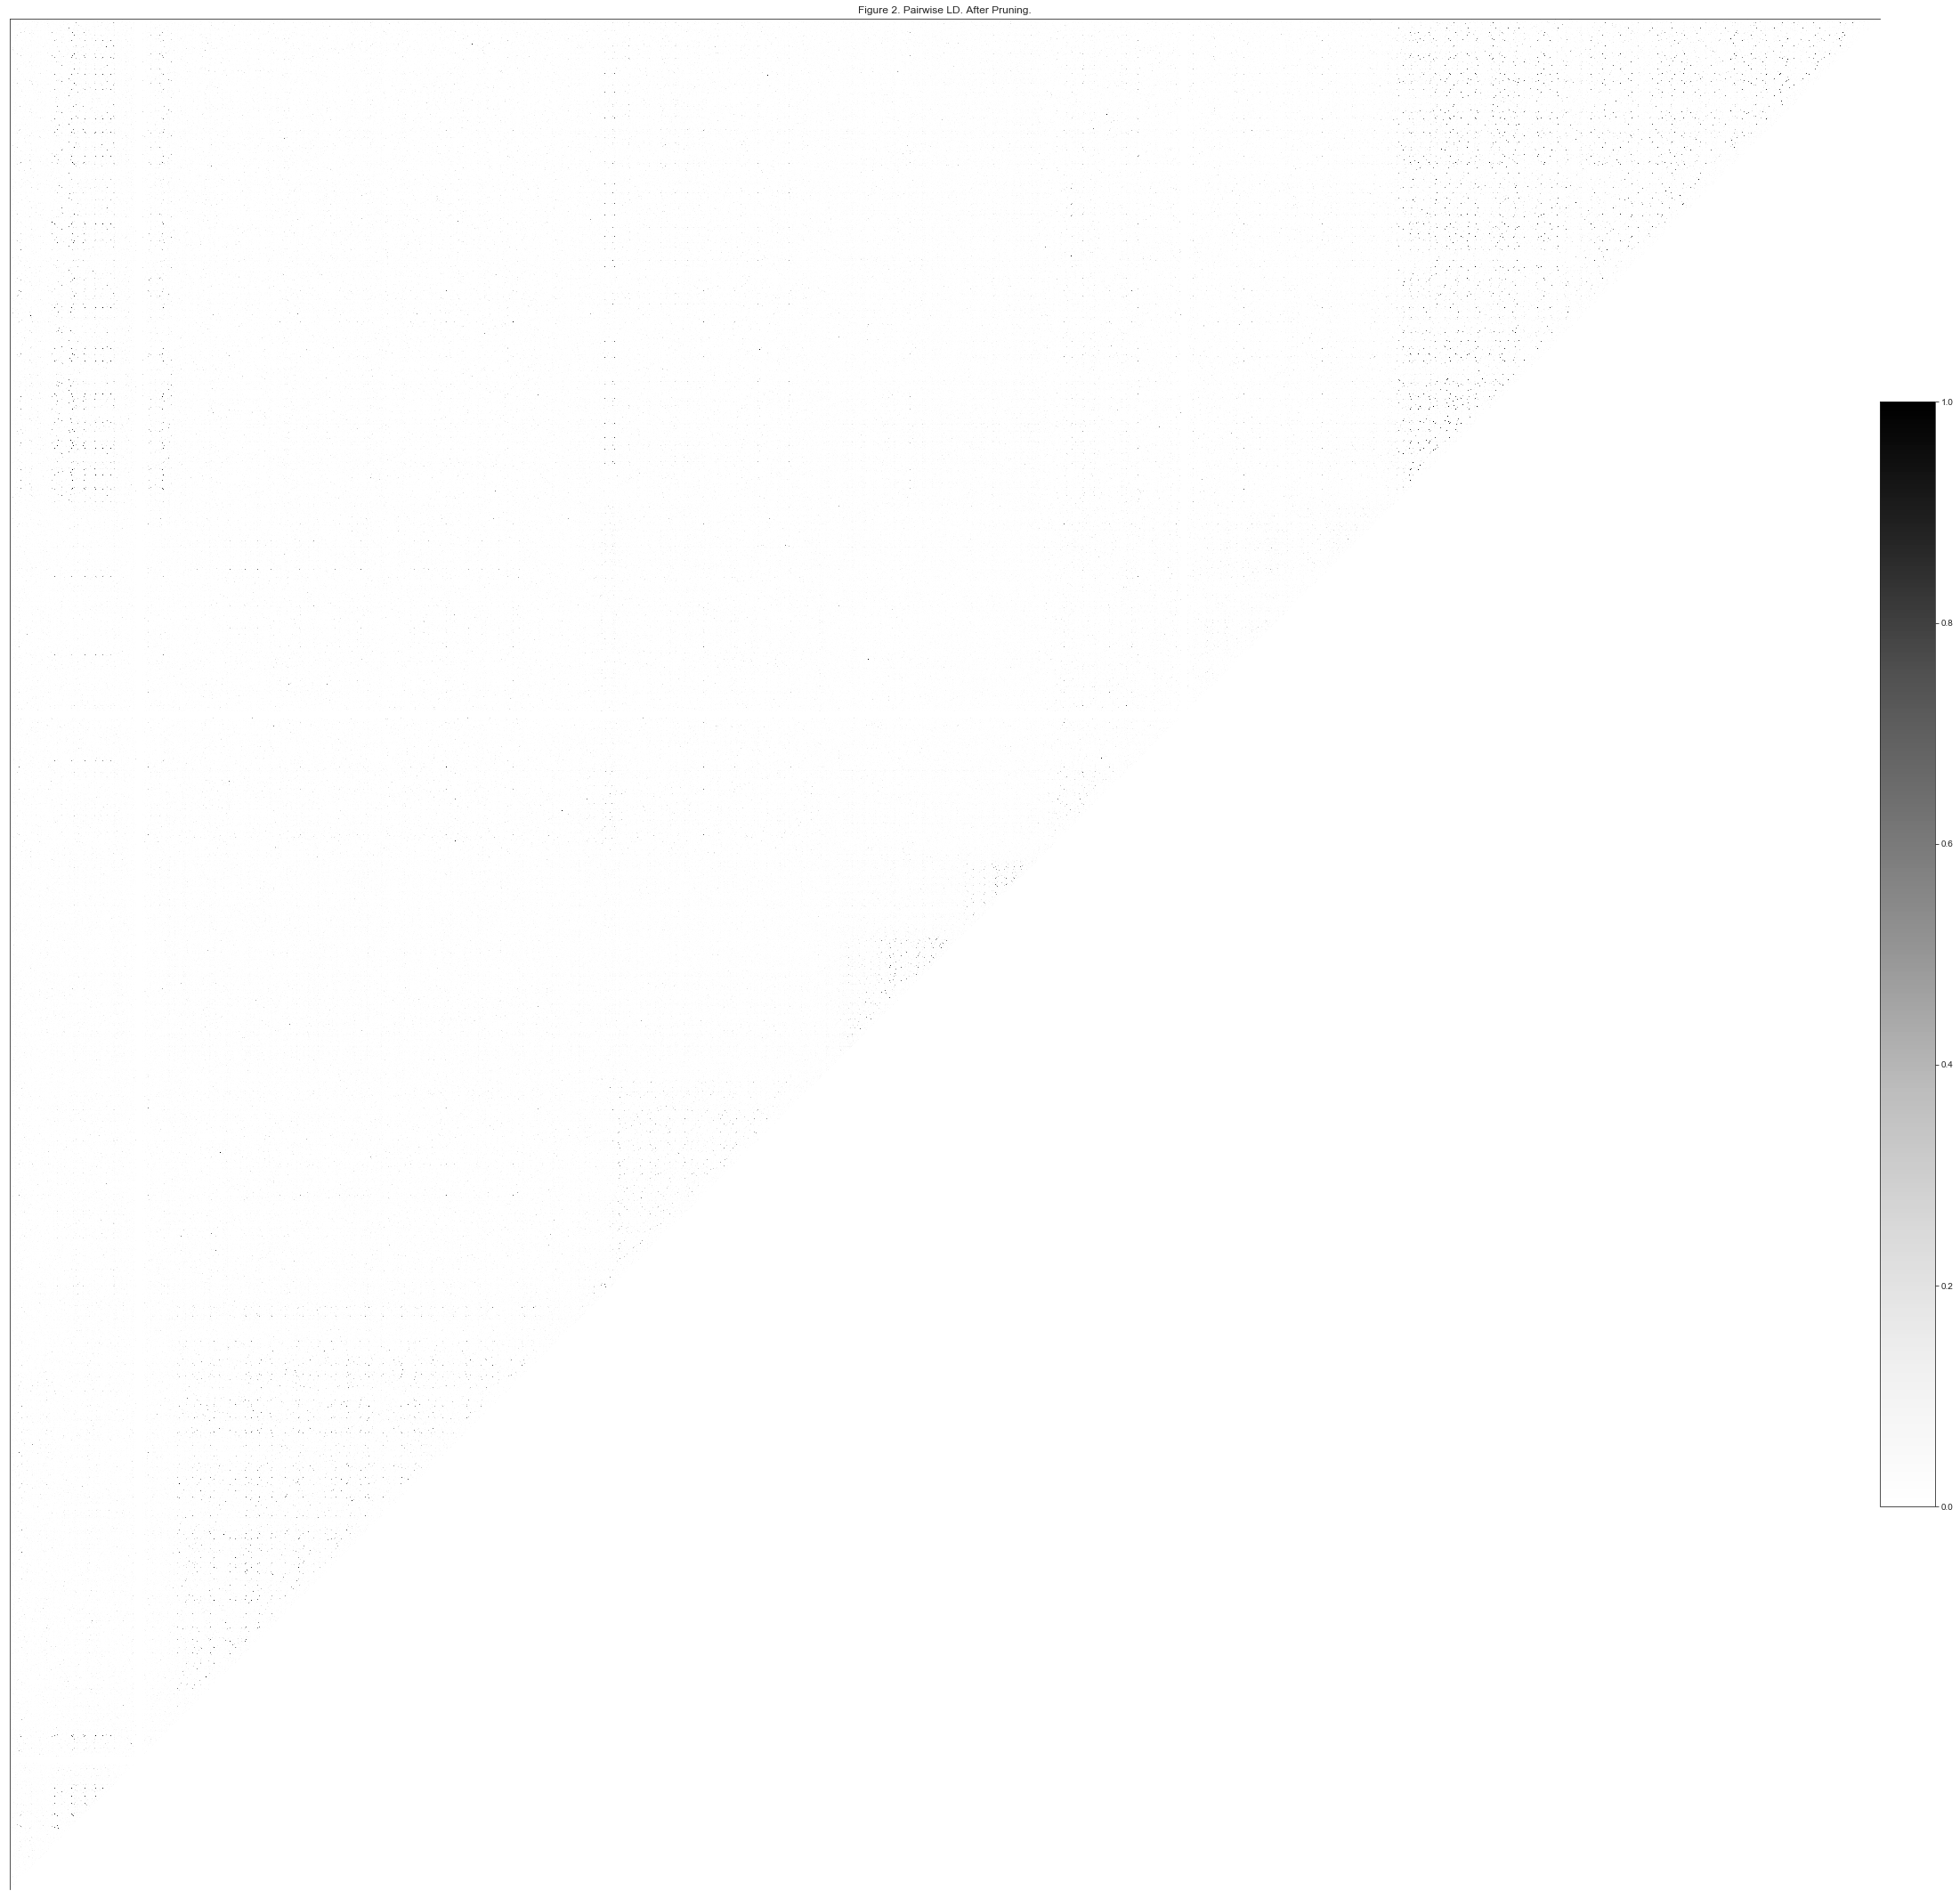

In [18]:
#reexamine our LD plot after we have pruned out the linked SNPs
plot_ld(FIN_CHS_gt_prune[:2500], 'Figure 2. Pairwise LD. After Pruning.')

*__Fig 2.__ this plot confirms that by scanning windows of SNPs in our sample genotype array and removing one pair in each linked polymorphism we are able to reduce the amount of linkage disequilibrium substantially*

In [22]:
#take our sample out of the compressed format and store it as a np array
FIN_CHS_gt_prune = FIN_CHS_gt_prune[:]
FIN_CHS_gt_prune.shape

(48335, 192)

__PCA via Singular Value Decomposition__

In [24]:
#using the allel.stats.decomposition function pca we can run PCA on our gt data using Singular Value Decomposition
coords_1, model_1 = allel.pca(FIN_CHS_gt_prune, n_components = 10, scaler = 'patterson')

In [40]:
#relabel our sample populations based on the original concatenation procedure
#so first FIN has first 100 samples and the remaining 92 members belong to the CHS population(which is what we expect)
FIN_coords = coords_1[0:100]
CHS_coords = coords_1[100:]

92

In [28]:
coords_1[0]

array([ 57.11631622,  17.40782078,   4.37308178, -66.66906166,
        19.76800036, -21.37690625,  10.47773275,  -9.29564127,
        18.41648846, -78.58231168])

In [23]:
help(allel.pca)

Help on function pca in module allel.stats.decomposition:

pca(gn, n_components=10, copy=True, scaler='patterson', ploidy=2)
    Perform principal components analysis of genotype data, via singular
    value decomposition.
    
    Parameters
    ----------
    
    gn : array_like, float, shape (n_variants, n_samples)
        Genotypes at biallelic variants, coded as the number of alternate
        alleles per call (i.e., 0 = hom ref, 1 = het, 2 = hom alt).
    n_components : int, optional
        Number of components to keep.
    copy : bool, optional
        If False, data passed to fit are overwritten.
    scaler : {'patterson', 'standard', None}
        Scaling method; 'patterson' applies the method of Patterson et al
        2006; 'standard' scales to unit variance; None centers the data only.
    ploidy : int, optional
        Sample ploidy, only relevant if 'patterson' scaler is used.
    
    Returns
    -------
    
    coords : ndarray, float, shape (n_samples, n_components)

In [30]:
#check the genotype shape for our CHS sample

(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)
(1045269,)

In [ ]:
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import PCA 

In [ ]:
#join our populations and select only the indices that don't contain multiallelic or biallelic singletons


In [9]:
FIN_new_gt

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 